## General Remarks <br>

+ The development of this Python script is mainly done with Jupyter notebook <br>
+ The script is run with Python 3.9.15<br>

---

##  Specific to `AIS_BBM`

+ This part of the script focus on BBM side of the GBM
+ Initial data pre-processing, model training and hyperparameter optimisation is performed with this script
+ Please remember to .gitignore the model generated using this script, as the file size can be quite big

---

### Package initialisation

+ Standard packages for ML is loaded 
+ The `joblib` package is used to save the generated model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import pickle
import joblib
import time 

### Data preprocessing :

+ Two data sources will be imported 
+ `AIS_weather_h_rename_copy.csv` will be used to complement the information for _true current direction_ and _true wind direction_ 
+ The resulting dataframe will be merged with the dataframe from the `AIS_weather_H_ok2_copy.csv` 
+ The data of the journey between Ronne and Sassnitz will be omitted, the filter is applied at 55.04°



In [2]:
# Parameter to plot in latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

# Load the data to the script

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]


dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [3]:
# Check for missing datapoints in dataset
print(dfmain.info())
print(dfpre.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            7453 non-null   int64         
 1   Time                                  7453 non-null   datetime64[ns]
 2   LON                                   7453 non-null   float64       
 3   LAT                                   7453 non-null   float64       
 4   Temperature above oceans              7453 non-null   float64       
 5   Air density above oceans              7337 non-null   float64       
 6   Max wave height                       6274 non-null   float64       
 7   Swell period                          6274 non-null   float64       
 8   Wind wave period                      6274 non-null   float64       
 9   Wave period                           6274 non-null   float64       
 10  

#### Histogram to show anomalies
+ The SOG is not per se anomalies, but the lower speed range may heavily affect the trained model, as the data are clustered at SOG = 0 kt
+ However for current speed, it is indeed anomaly, as this show abnornmal peak 

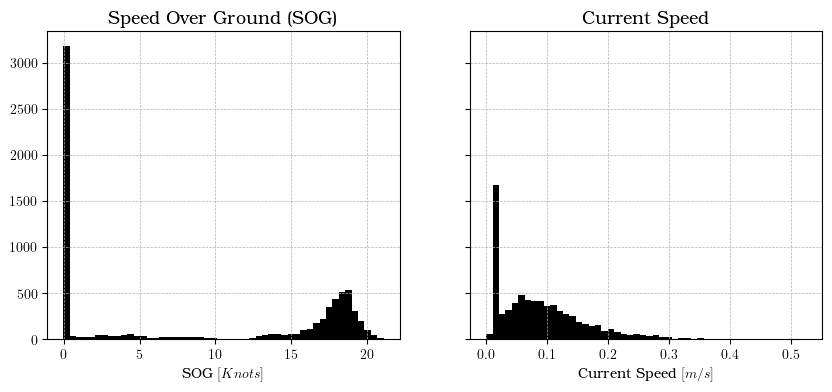

In [5]:
# Anomalies plot

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
dfmain['SOG'].hist(bins=50,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"SOG $[Knots]$")
plt.title(r"Speed Over Ground (SOG)", fontsize=13)
plt.sca(axes[1])
dfmain['Current Speed'].hist(bins=50,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"Current Speed $[m/s]$")
plt.title(r"Current Speed", fontsize=13)
plt.ylabel("")
plt.show()

### Calculation of ship's true north wind and current direction

+ All features are dropped except for `eastwind`, `northwind`, `eastcurrent`, `northcurrent` , `sog` and `cog`

In [6]:
# Drop all dulplicate feature in dataset "AIS_weather_h_rename_copy.csv"

dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


### Imputing missing values using `KNNImputer`
+ The dataset is first imputed
+ Then it is transformed

In [7]:
# Imputing the information for the missing east and north current data

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [8]:
# Transform
x_pre = imputer.transform(dfpre)

### Calculation of true north current and true north wind
+ The current and wind speed can be calculated using pythagoras theorem
+ The current and wind direction is divided into several conditions to ensure that they belong to the suitable quadrants

In [9]:
# Ensure that the imputed value maintains the same column heading 
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [10]:
# Calculate current and wind speed
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [11]:
# Calculate the True North wind direction and split them into quadrants

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))

In [12]:
# Calculate the True North current direction and split them into quadrants
condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [14]:
# Drop further unecessary feature before merging to main dataset
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [15]:
# Drop the wind speed and current speed from the original dataset as it contains outlier 
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [16]:
# Combine the the information of true north to main dataset
df = pd.concat([dfmain,dfpre],axis=1)

### SOG threshold
+ The threshold for the ships manouvering speed will be 5 knots ([Abebe20](https://doi.org/10.3390/app10072325),[Yan21](https://doi.org/10.1016/j.tre.2020.101930))
+ Alternatively, outlier rejection using &mu; &plusmn; 3&sigma; ([Gkerekos19](https://doi.org/10.1016/j.oceaneng.2019.106282)), this should increase the threshold to about 8 knots

In [17]:
# SOG threshold according to Abebe20 and Yan21

df = df[df['SOG'] > 5 ]

# # SOG threshold according to Gkerekos19

# df = df[df['SOG'] > 8 ]

In [18]:
# Length of dataset after speed filter
print(f"Length of speed filter dataset {len(df)}")

Length of speed filter dataset 3655


### Data split into training and test
+ The `random state` is 42, however to gain different datasets, change the `random state` to other numbers (arbitrary)

In [19]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.25, random_state=42)

In [20]:
# re-declare that df will be the dataframe used for training 
df = train_set

In [21]:
# Length of test dataset
print(f"Length of train dataset {len(train_set)}")
print(f"Length of test dataset {len(test_set)}")

Length of train dataset 2741
Length of test dataset 914


### Data Analysis before modelling
+ The steps in this section include: 
    + Feature deletion
    + Feature correlation 
    + Feature deletion 
    

In [24]:
# Remove features that have no impact on model training

df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)

In [26]:
# Renaming Features 

df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [27]:
df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

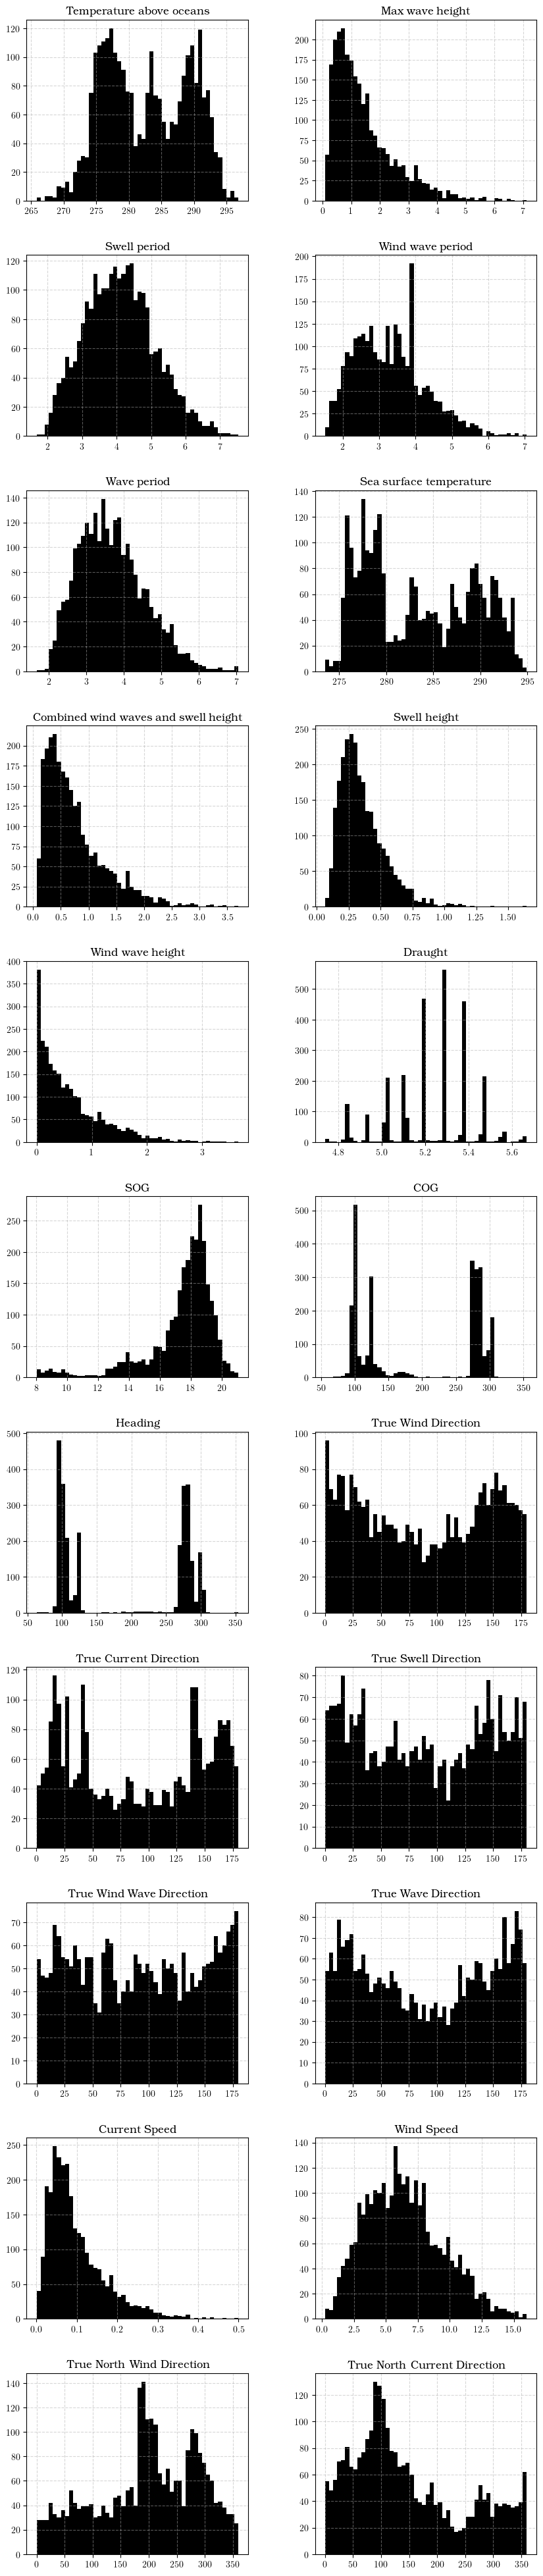

In [28]:
# Histogram plot of pre processed training dataset

# plt.rcParams.update(plt.rcParamsDefault) # Alter default value 
axes = df_ship.hist(bins=50,figsize=(10,50),color='black',grid=True,layout=(11,2))
for ax in axes.flatten():
    ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [30]:
# Drop variables such as date from the dataset

dfship_corr = df_ship2.drop(df_ship2.columns[[0,5,15,16,17,18,19,20,21]],axis=1)
print(dfship_corr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2741 entries, 1808 to 6933
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   waveheight           2566 non-null   float64
 1   swellperiod          2566 non-null   float64
 2   windwaveperiod       2566 non-null   float64
 3   waveperiod           2566 non-null   float64
 4   windwaveswellheight  2566 non-null   float64
 5   swellheight          2566 non-null   float64
 6   windwaveheight       2566 non-null   float64
 7   draught              2741 non-null   float64
 8   sog                  2741 non-null   float64
 9   cog                  2741 non-null   float64
 10  heading              2741 non-null   float64
 11  windspeed            2741 non-null   float64
 12  curspeed             2741 non-null   float64
dtypes: float64(13)
memory usage: 299.8 KB


In [31]:
# Function to plot correlation heatmap
def correlation_heatmap(df,fontsize):
    correlations = df.corr()
    # Parameter to plot in nice latex fonts
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    colormap = sns.color_palette("Reds")
    fig, ax = plt.subplots(figsize=(10,10))
    sns.set(font_scale = fontsize)
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',cmap="mako",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
                # ,annot_kws={'fontsize': 12, 'color':'k', 'alpha': 1})
    plt.show();

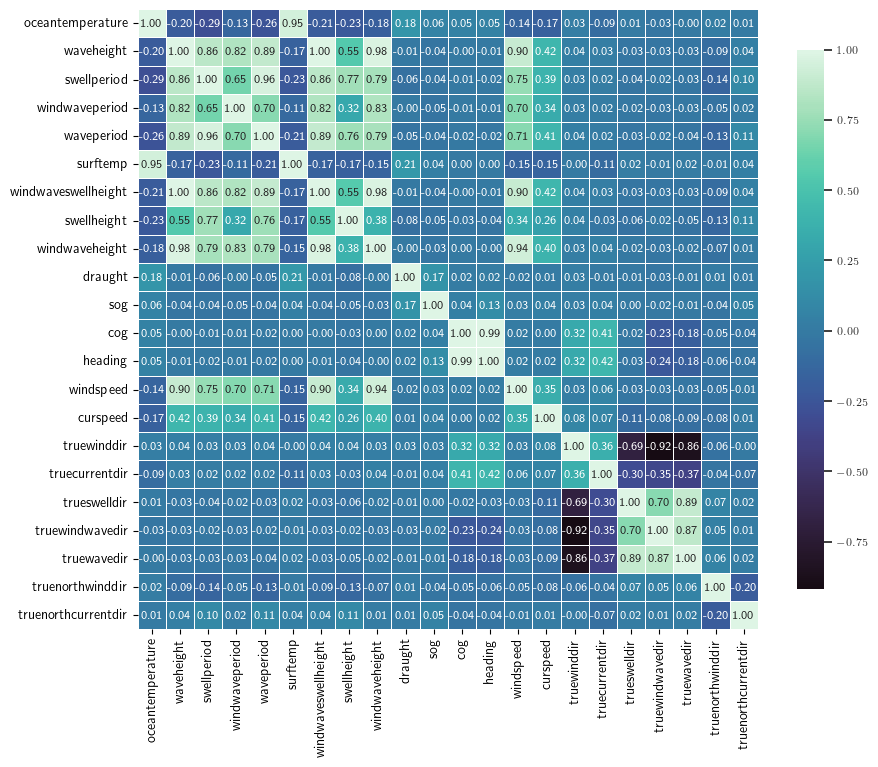

In [32]:
# Heatmap plot of overall dataset

df_ship_ovr = df_ship2
correlation_heatmap(df_ship_ovr,.7)

### Scientific Justification of High Correlation Filter [Abebe20](https://doi.org/10.3390/app10072325):

- According to [BitnerGregersen05](https://doi.org/10.1115/OMAE2005-67382), the wind wave swell height is equal to the square root of the square of swell wave and wind wave. Therefore Swell Wave Height and Wind Wave Height is dropped.
- According to [Bretschneider65](https://apps.dtic.mil/sti/citations/ad0612006), the max wave height is 2*H<sub>(1/3)</sub>. This correlation means that maximum wave height, `waveheight` is dropped
- According to [Torsetshaugen04](https://www.semanticscholar.org/paper/Simplified-Double-Peak-Spectral-Model-For-Ocean-Torsethaugen-Haver/0f1b1509791d441861ff6c2940dd13b1f939f149), The type of dominating wave (Wind wave/Swell) can be predicted from an equation which include the significant wave height and a certain threshold, therefore, it is decided that the wind wave period, swell period and consequently the true wind wave direction and true swell direction is to be dropped.
- True north direction carries less significance, instead the true directions are used which is direction of weather effect w.r.t. the ship bow

In [33]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truenorthcurrentdir','truenorthwinddir'],axis=1)

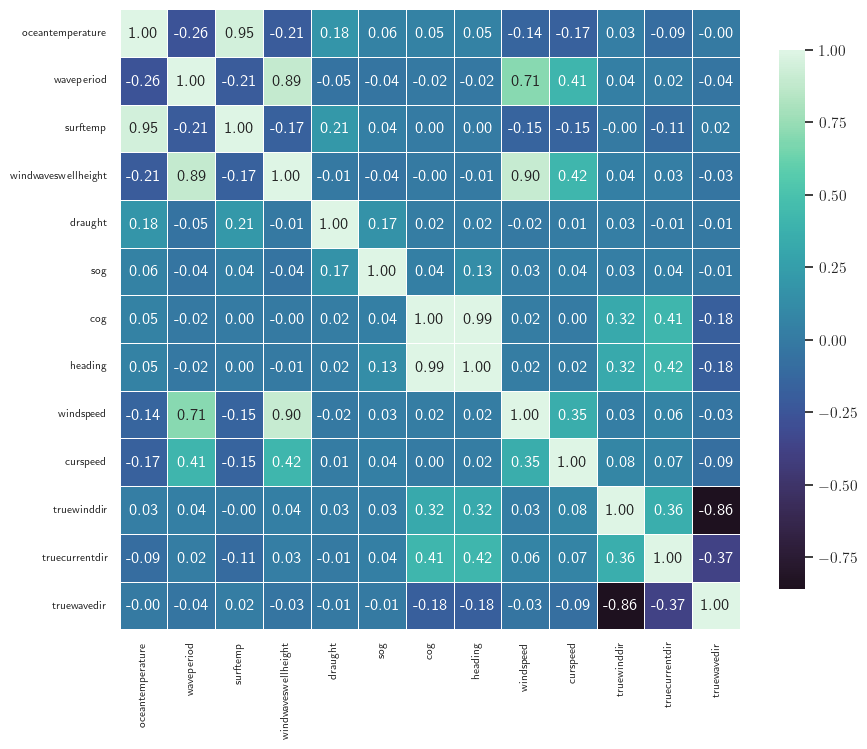

In [34]:
# Heatmap for training feature

correlation_heatmap(df_ship2,1)

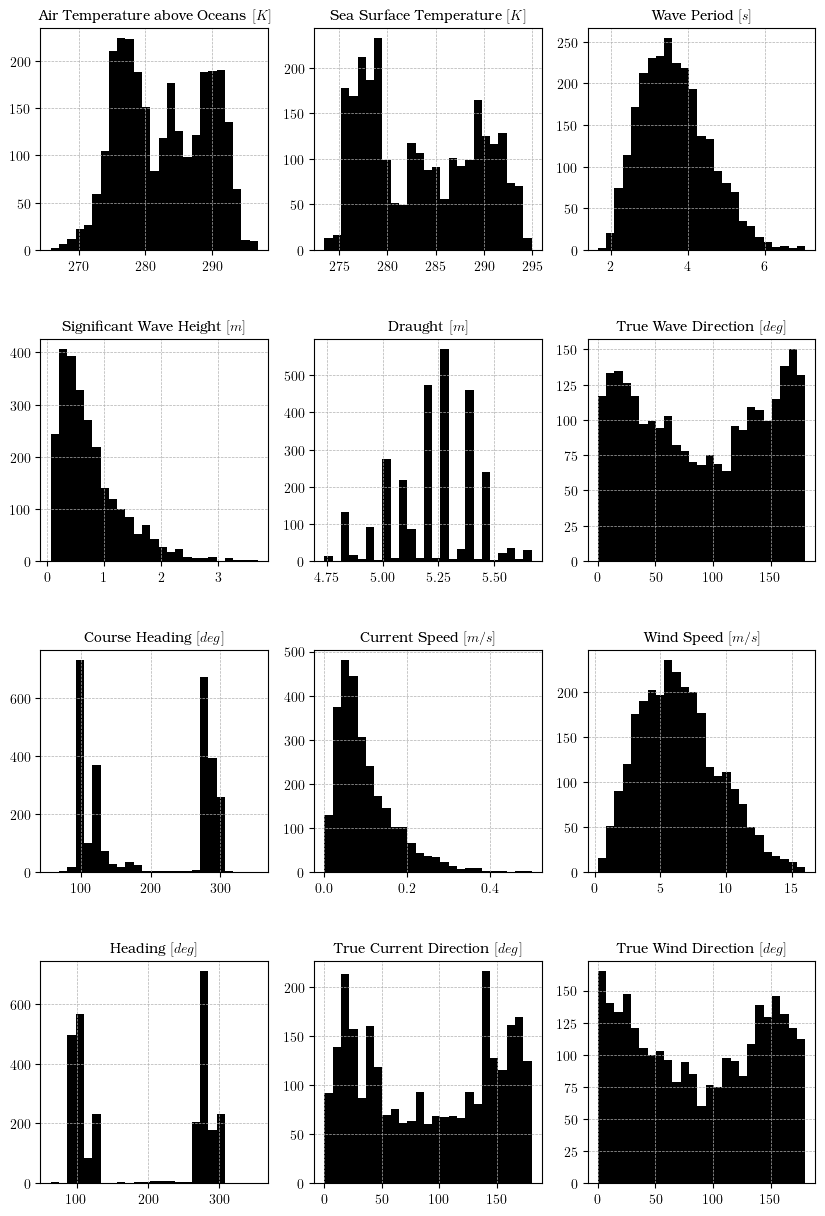

In [35]:
# demonstrate how to toggle the display of different elements:
# Histogram plot of final features and labels for training

fs = 10

plt.rcParams.update(plt.rcParamsDefault)
# Parameter to plot in nice latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

oceantemp = df_ship2['oceantemperature']
waveperiod = df_ship2['waveperiod']
surftemp = df_ship2['surftemp']
sigwave = df_ship2['windwaveswellheight']
draught = df_ship2['draught']
sog = df_ship2['sog']
cog = df_ship2['cog']
hdg = df_ship2['heading']
windspeed = df_ship2['windspeed']
curspeed = df_ship2['curspeed']
truewavedir = df_ship2['truewavedir']
truewind = df_ship2['truewinddir']
truecurrent = df_ship2['truecurrentdir']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

axes[0, 0].hist(oceantemp,bins=25,color='black')
axes[0, 0].set_title(r'Air Temperature above Oceans $[K]$', fontsize=fs)
axes[0, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 1].hist(surftemp,bins=25,color='black')
axes[0, 1].set_title(r'Sea Surface Temperature $[K]$', fontsize=fs)
axes[0, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 2].hist(waveperiod,bins=25,color='black')
axes[0, 2].set_title(r'Wave Period $[s]$', fontsize=fs)
axes[0, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 0].hist(sigwave,bins=25,color='black')
axes[1, 0].set_title(r'Significant Wave Height $[m]$', fontsize=fs)
axes[1, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 1].hist(draught  ,bins=25,color='black')
axes[1, 1].set_title(r'Draught $[m]$', fontsize=fs)
axes[1, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 2].hist(truewavedir,bins=25,color='black')
axes[1, 2].set_title(r'True Wave Direction $[deg]$', fontsize=fs)
axes[1, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 0].hist(cog,bins=25,color='black')
axes[2, 0].set_title(r'Course Heading $[deg]$', fontsize=fs)
axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 1].hist(curspeed,bins=25,color='black')
axes[2, 1].set_title(r'Current Speed $[m/s]$', fontsize=fs)
axes[2, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 2].hist(windspeed,bins=25,color='black')
axes[2, 2].set_title(r'Wind Speed $[m/s]$', fontsize=fs)
axes[2, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 0].hist(hdg,bins=25,color='black')
axes[3, 0].set_title(r'Heading $[deg]$', fontsize=fs)
axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 1].hist(truecurrent,bins=25,color='black')
axes[3, 1].set_title(r'True Current Direction $[deg]$', fontsize=fs)
axes[3, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 2].hist(truewind,bins=25,color='black')
axes[3, 2].set_title(r'True Wind Direction $[deg]$', fontsize=fs)
axes[3, 2].grid(True,linestyle = '--', linewidth = 0.5)

fig.subplots_adjust(hspace=0.4)
plt.show()

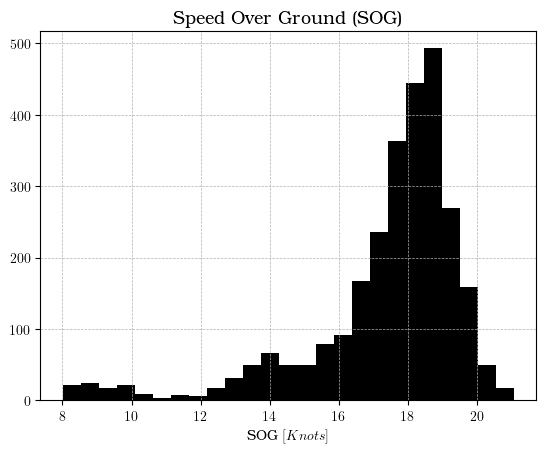

In [93]:
# Profile of SOG 

df_ship2['sog'].hist(bins=25,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"SOG $[Knots]$")
plt.title(r"Speed Over Ground (SOG)", fontsize=13)
plt.show()

### Imputing using KNN so that the all tree-based model by Sklearn may function 
+ The model by sklearn cannot accept `nan` values 
+ The imputing process is the same
    + Impute
    + Transform
    + Column heading matches the heading before imputing

In [37]:
# Impute

import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)

KNNImputer(n_neighbors=50)

In [38]:
# Transform

X = imputer.transform(df_ship2)

In [39]:
# Set heading to make sure they have same name 

df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [40]:
# Final check to ensure that the data points are all the same

print(df_ship2tr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2741 entries, 1808 to 6933
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     2741 non-null   float64
 1   waveperiod           2741 non-null   float64
 2   surftemp             2741 non-null   float64
 3   windwaveswellheight  2741 non-null   float64
 4   draught              2741 non-null   float64
 5   sog                  2741 non-null   float64
 6   cog                  2741 non-null   float64
 7   heading              2741 non-null   float64
 8   windspeed            2741 non-null   float64
 9   curspeed             2741 non-null   float64
 10  truewinddir          2741 non-null   float64
 11  truecurrentdir       2741 non-null   float64
 12  truewavedir          2741 non-null   float64
dtypes: float64(13)
memory usage: 299.8 KB
None


Preparation of Training data

In [41]:
x_train = df_ship2tr.drop(['sog'],axis=1)
y_train = df_ship2tr.sog

In [42]:
print("Amount of the x training dataset is:",len(x_train))

Amount of the x training dataset is: 2741


In [43]:
x_train.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000
mean,282.744909,3.667382,283.464916,0.754921,5.227819,197.015420,192.038613,6.466658,0.097879,88.323167,91.176006,90.561412
std,6.474733,0.855208,5.716568,0.531384,0.181386,87.555188,88.918785,3.012387,0.069854,56.260908,57.445682,56.011043
min,265.853058,1.672565,273.486084,0.065236,4.739825,56.023445,63.486661,0.248587,0.000980,0.029076,0.255190,0.055169
25%,277.083740,3.048167,278.241943,0.365932,5.109721,102.444570,100.862146,4.159611,0.048039,34.875743,35.662063,37.255746
50%,282.770996,3.581189,282.909424,0.629048,5.285188,175.751611,126.210204,6.177141,0.078174,87.195258,91.809057,90.224903
75%,288.839844,4.175565,288.942139,0.961625,5.377550,282.783993,279.875689,8.358903,0.128749,141.779251,144.390118,142.192149
max,296.830322,7.047197,294.928223,3.698143,5.667030,355.065691,354.145635,16.010816,0.499539,179.858625,179.997073,179.918071


In [44]:
y_train.describe()

count    2741.000000
mean       17.390241
std         2.276848
min         8.016867
25%        16.831242
50%        18.010847
75%        18.752019
max        21.070514
Name: sog, dtype: float64

Modelling using Random Forest Regressor 

In [45]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr = RandomForestRegressor(random_state=42)
start_rf = time.time()
model_rfr_ftr.fit(x_train,y_train)
end_rf = time.time()
print(f"Training time: {end_rf-start_rf:0.4}s ")

Training time: 4.063s 


HPO RFR for validation data

In [46]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr_hpov = RandomForestRegressor(n_estimators = 100,
                                            min_samples_split = 2,
                                            min_samples_leaf = 1,
                                            max_features = 10,
                                            max_depth=120,
                                            random_state=42)

# # Prev HPO: (n_estimators = 900,min_samples_split = 2,min_samples_leaf = 2,# max_features = 9,max_depth=200,random_state=42)

start_rfo = time.time()
model_rfr_ftr_hpov.fit(x_train,y_train)
end_rfo = time.time()
print(f"Training time: {end_rfo-start_rfo:0.4}s ")

Training time: 3.433s 


Modelling using ETR

In [47]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr = ExtraTreesRegressor(random_state=42)
start_et = time.time()
model_etr.fit(x_train,y_train)
end_et = time.time()
print(f"Training time: {end_et-start_et:0.4}s ")

Training time: 0.9398s 


HPO ETR for validation data

In [48]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr_hpov = ExtraTreesRegressor(random_state=42,
                                n_estimators=800,
                                min_samples_split=9,
                                min_samples_leaf=1,
                                max_features=12,
                                max_depth=120,
                                )
# Prev HPO (random_state=42,n_estimators=600,max_depth=10)

start_eto = time.time()
model_etr_hpov.fit(x_train,y_train)
end_eto = time.time()
print(f"Training time: {end_eto-start_eto:0.4}s")

Training time: 4.441s


Modelling using Decision Tree Regressor

In [49]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor()
start_dtr = time.time()
model_dtr.fit(x_train,y_train)
end_dtr = time.time()
print(f"Training time: {end_dtr-start_dtr:0.4}s")

Training time: 0.04243s


HPO DTR for validation data

In [50]:
from sklearn.tree import DecisionTreeRegressor
model_dtr_hpov = DecisionTreeRegressor(min_samples_split=7,
                                  min_samples_leaf=10,
                                  max_features=12,
                                  max_depth=8)
# Old HPO (min_samples_split=2,min_samples_leaf=3,max_features=12,max_depth=10)
start_dtro = time.time()
model_dtr_hpov.fit(x_train,y_train)
end_dtro = time.time()
print(f"Training time: {end_dtro-start_dtro:0.4}s")

Training time: 0.02101s


Modelling using Multiple Linear Regression

In [51]:
from sklearn import linear_model
model_mlr = linear_model.LinearRegression()
start_mlr = time.time()
model_mlr.fit(x_train,y_train)
end_mlr = time.time()
print(f"Training time: {end_mlr-start_mlr:0.4}s")

Training time: 0.004s


Save model to local directory

In [52]:
# # # Saving the model to local directory

# filename = 'savemodel_rfr_ftr.sav'
# joblib.dump(model_rfr_ftr,filename)

# filename = 'savemodel_rfr_ftr_hpov.sav'
# joblib.dump(model_rfr_ftr_hpov,filename)

# filename = 'savemodel_etr.sav'
# joblib.dump(model_etr,filename)

# filename = 'savemodel_etr_hpov.sav'
# joblib.dump(model_etr_hpov,filename)

# filename = 'savemodel_dtr_ftr.sav'
# joblib.dump(model_dtr,filename)

# filename = 'savemodel_dtr_hpov.sav'
# joblib.dump(model_dtr_hpov,filename)

# filename = 'savemodel_mlr_ftr.sav'
# joblib.dump(model_mlr,filename)

Model Evaluation

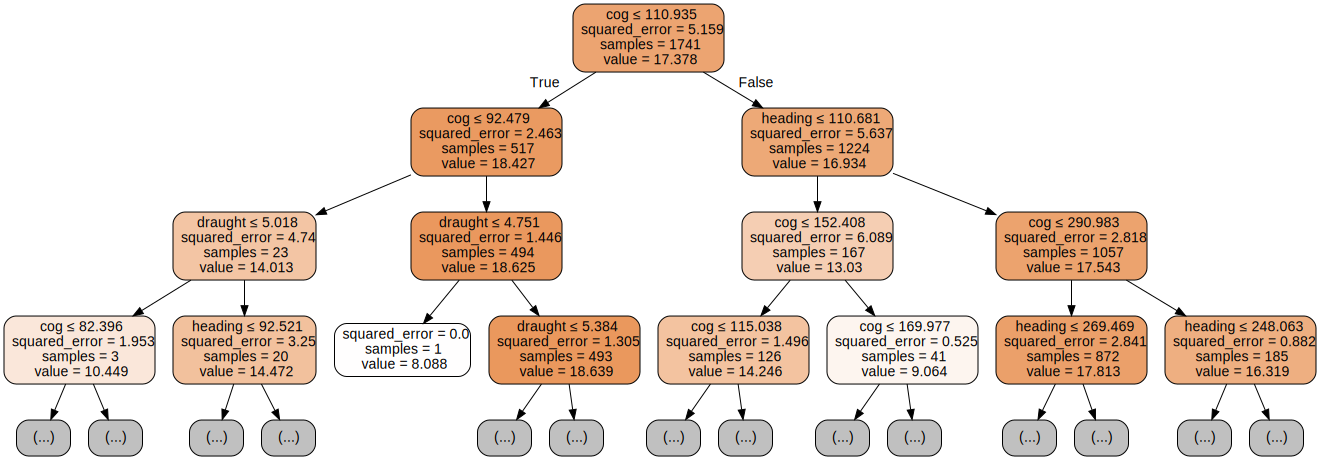

In [53]:
# Plot tree using graphviz, generate 1st tree in RFR (Graphviz must be installed in local computer)

from IPython.display import display
from sklearn import tree
import graphviz

dot_data_rfr = tree.export_graphviz(model_rfr_ftr_hpov.estimators_[1], 
                  feature_names=x_train.columns.values.tolist(),  
                #   class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                   max_depth=3,
                           )

display(graphviz.Source(dot_data_rfr))

# Only uncomment when about to generate PNG file, it will create source file that cannot be ignored by git

# graph = graphviz.Source(dot_data_rfr)
# graph.format = 'png'
# graph.render('rfr_mod_it1',view=True)

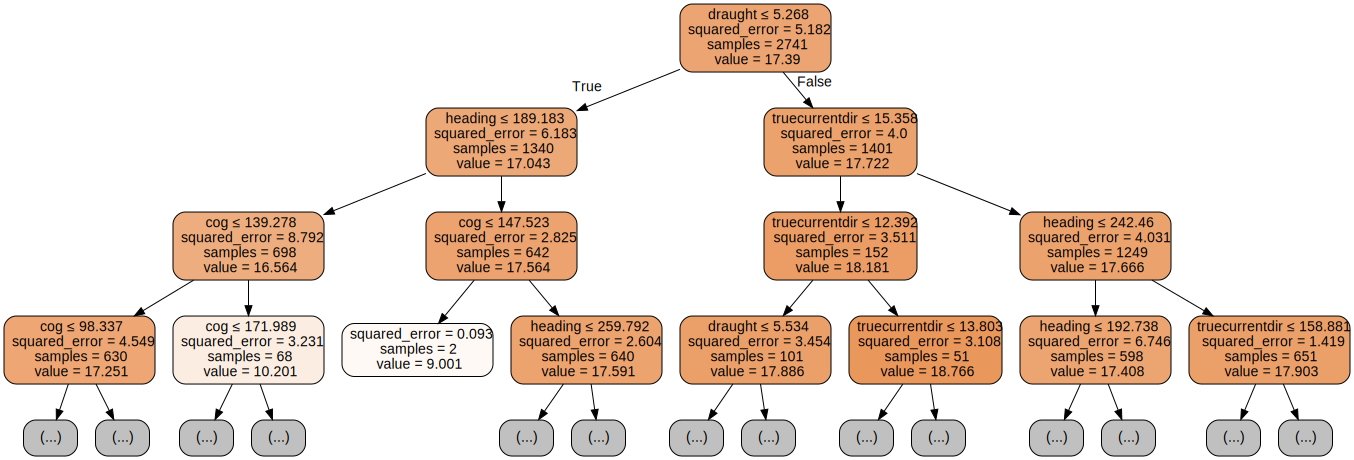

In [54]:
# Generate 1st tree in ETR

dot_data_etr = tree.export_graphviz(model_etr_hpov.estimators_[1], 
                  feature_names=x_train.columns.values.tolist(),  
                #   class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                   max_depth=3,
                           )

display(graphviz.Source(dot_data_etr))

# Only uncomment when about to generate PNG file, it will create source file that cannot be ignored by git

# graph = graphviz.Source(dot_data_etr)
# graph.format = 'png'
# graph.render('etr_mod_it1',view=True)

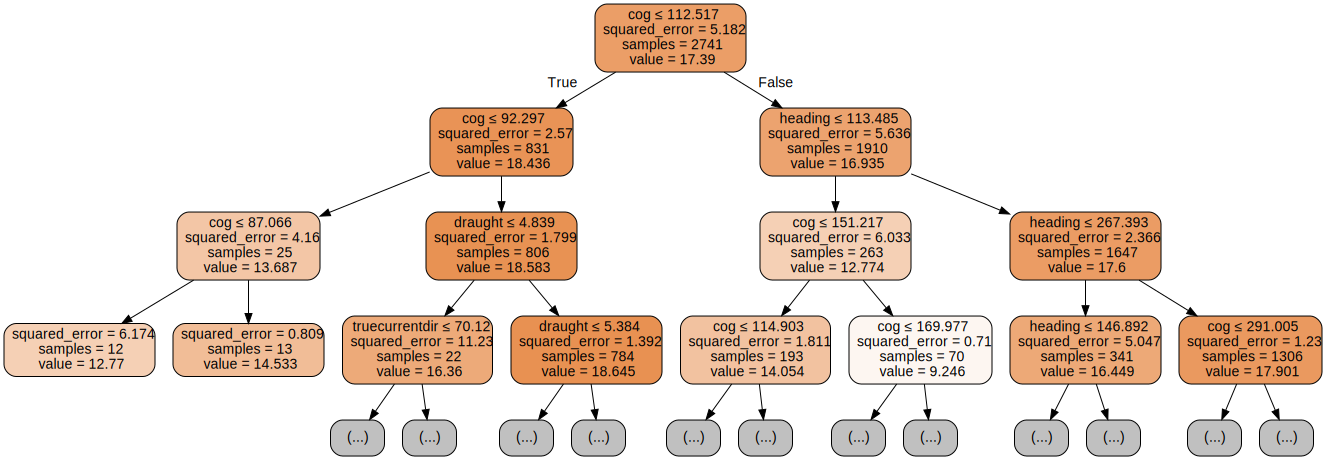

In [55]:
# Generate 1st tree in DTR

dot_data_dtr = tree.export_graphviz(model_dtr_hpov, 
                  feature_names=x_train.columns.values.tolist(),  
                #   class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                   max_depth=3,
                           )

display(graphviz.Source(dot_data_dtr))

# Only uncomment when about to generate PNG file, it will create source file that cannot be ignored by git

# graph = graphviz.Source(dot_data_dtr)
# graph.format = 'png'
# graph.render('dtr_mod_1tree',view=True)

In [56]:
def model_importance(model_type):
    mod_imp = model_type.feature_importances_
    df_mod_imp = pd.DataFrame(mod_imp,index= x_train.columns,columns=["Importance"])
    print(df_mod_imp.sort_values(by=['Importance'],ascending=False))


In [57]:
# def plot_feature_importance(model_type,names,model_name):

#     importance = model_type.feature_importances_

#     #Create arrays from feature importance and feature names
#     feature_importance = np.array(importance)
#     feature_names = np.array(names)

#     #Create a DataFrame using a Dictionary
#     data={'feature_names':feature_names,'feature_importance':feature_importance}
#     fi_df = pd.DataFrame(data)

#     #Sort the DataFrame in order decreasing feature importance
#     fi_sorted = fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#     #Define size of bar plot
#     plt.figure(figsize=(5,4))
#     #Plot Searborn bar chart
#     sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],color='black')
#     #Add chart labels
#     plt.title(f"Feature Importance of {model_name}")
#     plt.grid(linestyle = '--', linewidth = 0.4,axis='x')
#     plt.xlabel('Feature Importance')
#     plt.xlim(0,0.7)
#     plt.ylabel('Feature Names')


In [58]:
def plot_feature_importance(model_type,names,model_name):

    importance = model_type.feature_importances_

    # #Create arrays from feature importance and feature names
    # feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Sort feature importances in ascending order
    sorted_indices = np.argsort(importance)
    sorted_feature_importances = importance[sorted_indices]
    sorted_feature_names = np.array(names)[sorted_indices]  # Replace with your actual feature names

    # Create a bar plot for sorted feature importances
    plt.figure(figsize=(10,6))
    plt.barh(range(len(sorted_feature_names)), sorted_feature_importances, color='black')
    plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
    plt.xlabel('Importance Value')
    plt.ylabel('Feature Name')
    plt.title(f'Feature Importances of {model_name}')
    plt.xlim(0,0.7)
    plt.grid(linestyle = '--', linewidth = 0.4,axis='x')
    plt.tight_layout()

    # Show importance values on the plot
    for i, v in enumerate(sorted_feature_importances):
        plt.text(v + 0.001, i, str(round(v, 4)), color='black', fontweight='bold')


In [59]:
def plot_feature_importance_norank(model_type,names,model_name):

    importance = model_type.feature_importances_

    # #Create arrays from feature importance and feature names
    # feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Sort feature importances in ascending order
    sorted_indices = np.argsort(importance)
    # Exclude the first and second-ranked features
    exclude_indices = [sorted_indices[10], sorted_indices[11]]
    remaining_indices = [i for i in sorted_indices if i not in exclude_indices]
    remaining_feature_importances = importance[remaining_indices]
    remaining_feature_names = [feature_names[i] for i in remaining_indices]

    # Sort the remaining feature importances in ascending order
    sorted_remaining_indices = np.argsort(remaining_feature_importances)
    sorted_feature_importances = remaining_feature_importances[sorted_remaining_indices]
    sorted_feature_names = [remaining_feature_names[i] for i in sorted_remaining_indices]


    # Create a bar plot for sorted feature importances
    plt.figure(figsize=(10,6))
    plt.barh(range(len(sorted_feature_names)), sorted_feature_importances, color='black')
    plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
    plt.xlabel('Importance Value')
    plt.ylabel('Feature Name')
    plt.title(f'Feature Importances of {model_name}')
    plt.xlim(0,0.025)
    plt.grid(linestyle = '--', linewidth = 0.4,axis='x')
    plt.tight_layout()

    # Show importance values on the plot
    for i, v in enumerate(sorted_feature_importances):
        plt.text(v + 0.001, i, str(round(v, 4)), color='black', fontweight='bold')


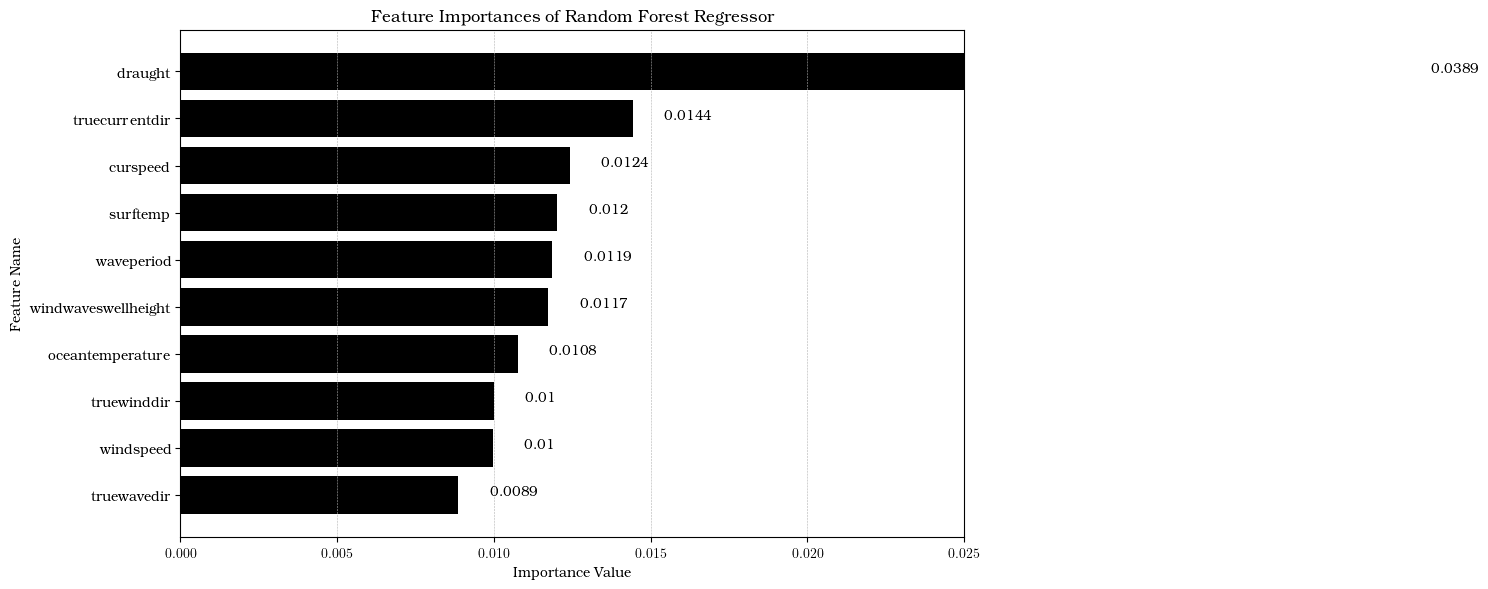

In [60]:
plot_feature_importance_norank(model_rfr_ftr_hpov,x_train.columns,'Random Forest Regressor')
plt.show()

                     Importance
heading                0.449670
cog                    0.409371
draught                0.038896
truecurrentdir         0.014430
curspeed               0.012427
surftemp               0.012020
waveperiod             0.011861
windwaveswellheight    0.011738
oceantemperature       0.010754
truewinddir            0.009998
windspeed              0.009974
truewavedir            0.008861


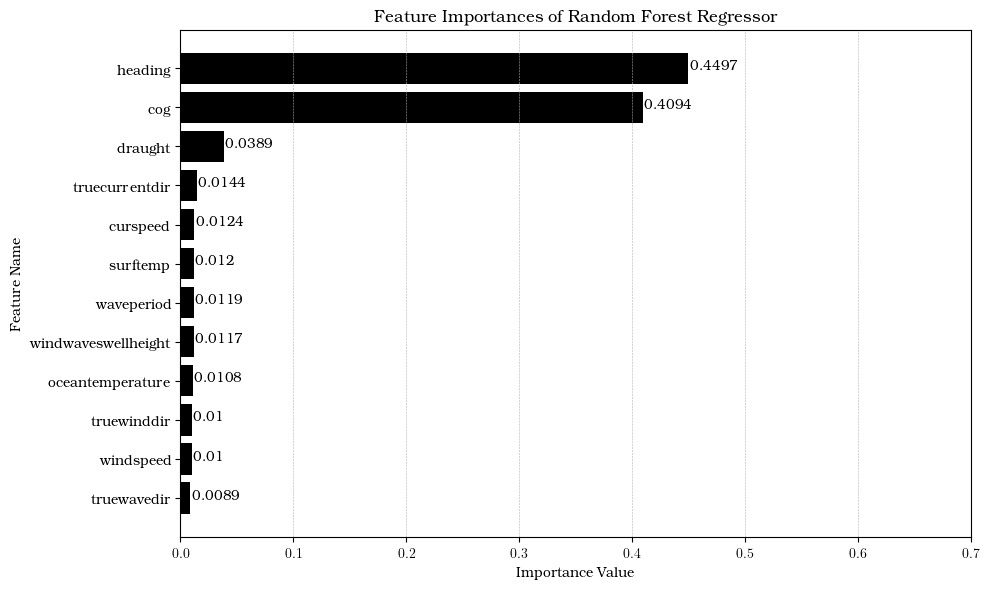

In [61]:
model_importance(model_rfr_ftr_hpov)
plot_feature_importance(model_rfr_ftr_hpov,x_train.columns,'Random Forest Regressor')
plt.show()


                     Importance
cog                    0.608483
heading                0.278143
draught                0.034852
truecurrentdir         0.012120
waveperiod             0.012086
windwaveswellheight    0.010892
curspeed               0.008095
windspeed              0.007955
surftemp               0.007481
oceantemperature       0.007293
truewavedir            0.006742
truewinddir            0.005857


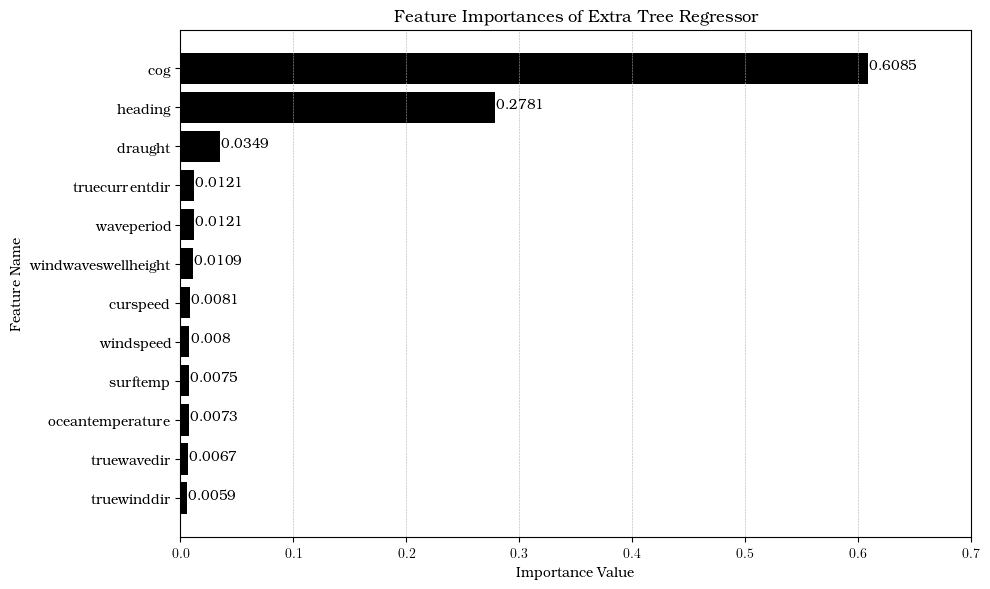

In [62]:
model_importance(model_etr_hpov)
plot_feature_importance(model_etr_hpov,x_train.columns,'Extra Tree Regressor')
plt.show()

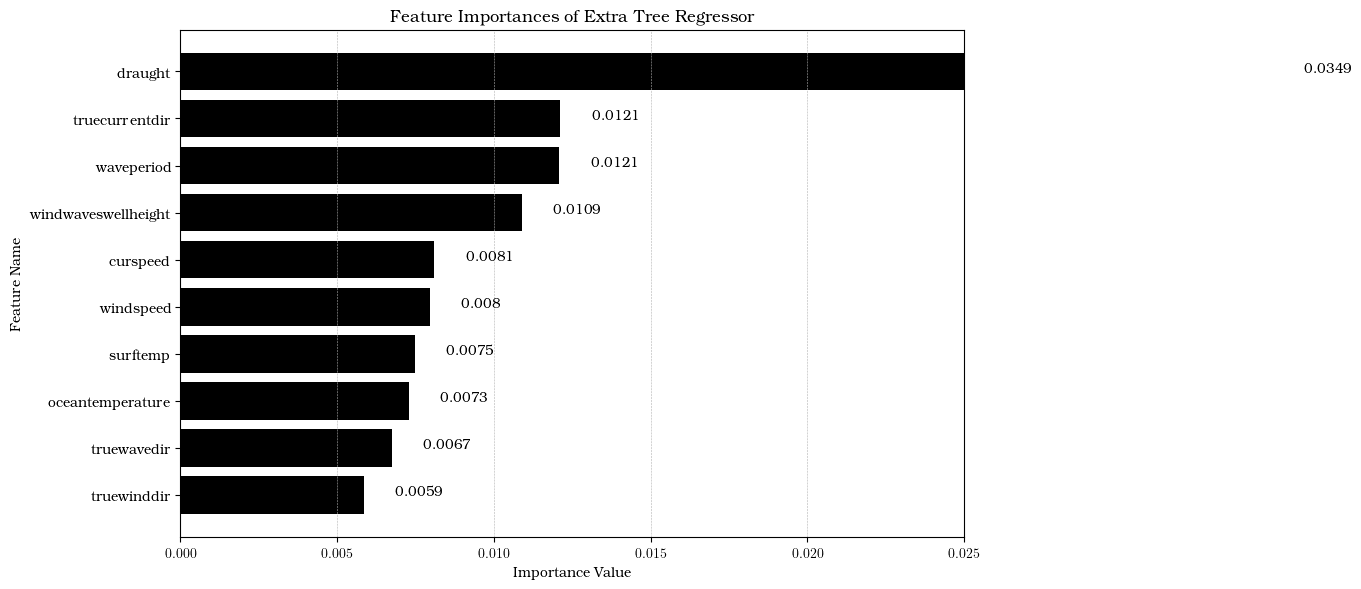

In [63]:
plot_feature_importance_norank(model_etr_hpov,x_train.columns,'Extra Tree Regressor')
plt.show()

                     Importance
heading                0.602123
cog                    0.358863
draught                0.019531
truecurrentdir         0.006343
waveperiod             0.005195
curspeed               0.002414
windspeed              0.001738
truewavedir            0.001556
oceantemperature       0.001221
truewinddir            0.000510
windwaveswellheight    0.000505
surftemp               0.000000


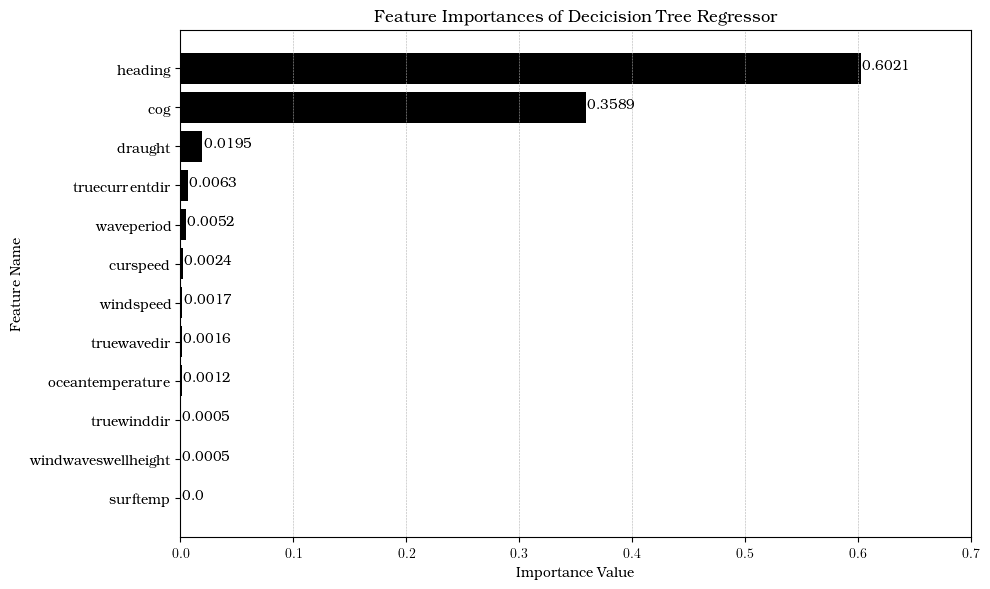

In [64]:
model_importance(model_dtr_hpov)
plot_feature_importance(model_dtr_hpov,x_train.columns,'Decicision Tree Regressor')
plt.show()

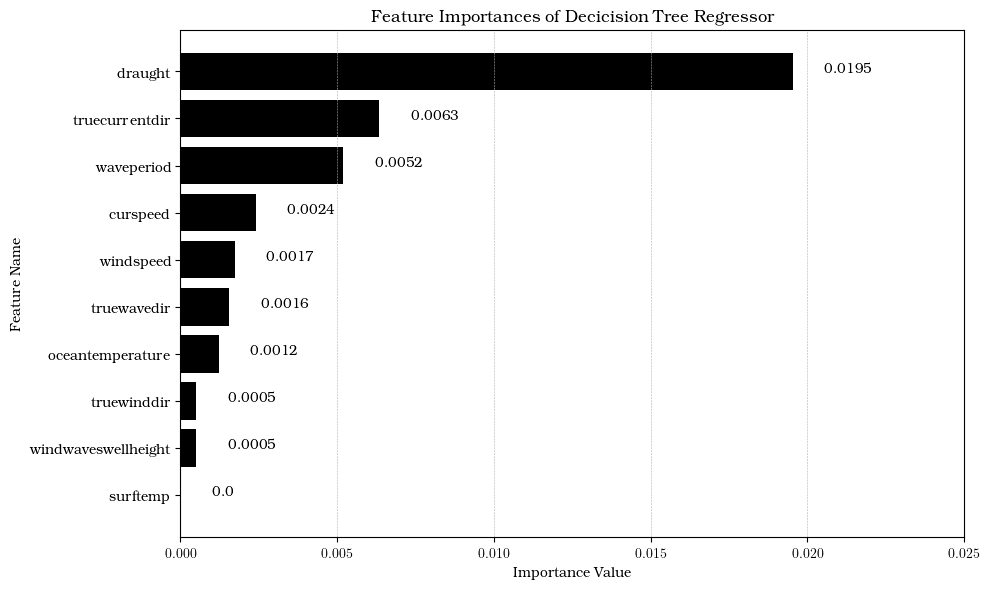

In [65]:
plot_feature_importance_norank(model_dtr_hpov,x_train.columns,'Decicision Tree Regressor')
plt.show()

In [66]:
def evaluate(model, features_x, labels_y):
    from sklearn.model_selection import cross_val_score

    score_r2 = cross_val_score(model,features_x,labels_y,
                           scoring='r2',cv=10)
    rsquared = score_r2.mean()
    stadev_rsquared = score_r2.std()
    max_rsquared = score_r2.max()
    min_rsquared = score_r2.min()

    score_expVar = cross_val_score(model,features_x,labels_y,
                           scoring='explained_variance',cv=10)
    expVar = score_expVar.mean()
    stadev_expVar = score_expVar.std()
    max_expVar = score_expVar.max()
    min_expVar = score_expVar.min()

    score_MAE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_mean_absolute_error',cv=10)
    MAE = -score_MAE.mean()
    stadev_MAE = score_MAE.std()
    max_MAE = -score_MAE.max()
    min_MAE = -score_MAE.min()

    score_MAD = cross_val_score(model,features_x,labels_y,
                           scoring='neg_median_absolute_error',cv=10)
    MAD = -score_MAD.mean()
    stadev_MAD = score_MAD.std()
    max_MAD = -score_MAD.max()
    min_MAD = -score_MAD.min()



    score_MSE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_root_mean_squared_error',cv=10)
    score_RMSE = np.sqrt(-score_MSE)
    RMSE = score_RMSE.mean()
    stadev_RMSE = score_RMSE.std()
    max_RMSE = score_RMSE.max()
    min_RMSE = score_RMSE.min()


    print(f"Model Performance of {model}")
    print(f"R^2 = {rsquared:0.4f}, std = {stadev_rsquared:0.4f}, max = {max_rsquared:0.4f}, min = {min_rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}, std = {stadev_expVar:0.4f}, max = {max_expVar:0.4f}, min = {min_expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}, std = {stadev_MAE:0.4f}, max = {max_MAE:0.4f}, min = {min_MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}, std = {stadev_RMSE:0.4f}, max = {max_RMSE:0.4f}, min = {min_RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}, std = {stadev_MAD:0.4f}, max = {max_MAD:0.4f}, min = {min_MAD:0.4f}\n")

    return score_r2,score_expVar,score_MAE,score_RMSE,score_MAD        

Evaluation of RFR

In [67]:
r2_rf,expVar_rf,MAE_rf,RMSE_rf,MAD_rf = evaluate(model_rfr_ftr,x_train,y_train)

Model Performance of RandomForestRegressor(random_state=42)
R^2 = 0.8202, std = 0.0359, max = 0.8791, min = 0.7603
explained Variance = 0.8209, std = 0.0355, max = 0.8791, min = 0.7603
MAE = 0.6226, std = 0.0370, max = 0.5563, min = 0.6885
RMSE = 0.9729, std = 0.0470, max = 1.0728, min = 0.9193
MAD = 0.4304, std = 0.0447, max = 0.3347, min = 0.5092



In [68]:
# Optimised model performance

r2_rfo,expVar_rfo,MAE_rfo,RMSE_rfo,MAD_rfo = evaluate(model_rfr_ftr_hpov,x_train,y_train)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 = 0.8241, std = 0.0328, max = 0.8774, min = 0.7724
explained Variance = 0.8247, std = 0.0323, max = 0.8774, min = 0.7725
MAE = 0.6208, std = 0.0335, max = 0.5638, min = 0.6760
RMSE = 0.9680, std = 0.0416, max = 1.0590, min = 0.9229
MAD = 0.4335, std = 0.0398, max = 0.3616, min = 0.4971



Evaluation of ETR

In [69]:
r2_et,expVar_et,MAE_et,RMSE_et,MAD_et = evaluate(model_etr,x_train,y_train)

Model Performance of ExtraTreesRegressor(random_state=42)
R^2 = 0.8469, std = 0.0342, max = 0.8961, min = 0.7872
explained Variance = 0.8475, std = 0.0334, max = 0.8965, min = 0.7883
MAE = 0.5925, std = 0.0220, max = 0.5623, min = 0.6319
RMSE = 0.9330, std = 0.0256, max = 0.9770, min = 0.8955
MAD = 0.4171, std = 0.0327, max = 0.3575, min = 0.4645



In [70]:
# Optimised model performance 

r2_eto,expVar_eto,MAE_eto,RMSE_eto,MAD_eto = evaluate(model_etr_hpov,x_train,y_train)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 = 0.8404, std = 0.0318, max = 0.8881, min = 0.7899
explained Variance = 0.8409, std = 0.0312, max = 0.8882, min = 0.7924
MAE = 0.5999, std = 0.0256, max = 0.5614, min = 0.6370
RMSE = 0.9436, std = 0.0258, max = 1.0003, min = 0.8954
MAD = 0.4264, std = 0.0381, max = 0.3573, min = 0.4820



Evaluation of DTR

In [71]:
r2_dt,expVar_dt,MAE_dt,RMSE_dt,MAD_dt = evaluate(model_dtr,x_train,y_train)

Model Performance of DecisionTreeRegressor()
R^2 = 0.6691, std = 0.0726, max = 0.7646, min = 0.5530
explained Variance = 0.6735, std = 0.0787, max = 0.7980, min = 0.5360
MAE = 0.8658, std = 0.0411, max = 0.8030, min = 0.9315
RMSE = 1.1448, std = 0.0249, max = 1.1891, min = 1.1133
MAD = 0.5849, std = 0.0528, max = 0.4990, min = 0.6472



In [72]:
# Optimised model performance

r2_dto,expVar_dto,MAE_dto,RMSE_dto,MAD_dto = evaluate(model_dtr_hpov,x_train,y_train)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 = 0.7659, std = 0.0426, max = 0.8442, min = 0.7126
explained Variance = 0.7668, std = 0.0424, max = 0.8442, min = 0.7126
MAE = 0.7070, std = 0.0453, max = 0.6196, min = 0.7880
RMSE = 1.0391, std = 0.0324, max = 1.0922, min = 0.9838
MAD = 0.4714, std = 0.0537, max = 0.3705, min = 0.5847



Evaluation of MLR 

In [73]:
r2_mlr,expVar_mlr,MAE_mlr,RMSE_mlr,MAD_mlr = evaluate(model_mlr,x_train,y_train)

Model Performance of LinearRegression()
R^2 = 0.3787, std = 0.2151, max = 0.6489, min = -0.1529
explained Variance = 0.3801, std = 0.2145, max = 0.6489, min = -0.1512
MAE = 1.1923, std = 0.0840, max = 1.0964, min = 1.3748
RMSE = 1.3172, std = 0.1026, max = 1.5457, min = 1.2048
MAD = 0.9629, std = 0.0676, max = 0.8445, min = 1.0887



Prediction vs Actual

In [74]:
# Parameter to reset plot properties to default and change the font to tex

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

Learning Curves

In [75]:
# Functions for MAE and Rsquared plots
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit ,learning_curve

def learn_plotrmse(model,x_data,y_data,model_name):
    train_sizes, train_scores, test_scores = learning_curve(estimator = model, X=x_data, y=y_data,
                                                        cv=10, train_sizes=np.linspace(0.1, 1.0, 20),
                                                        n_jobs=-1,scoring="neg_mean_absolute_error")
	# Parameter to plot in nice latex fonts
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    #
    # Calculate training and test mean and std
    #
    train_scores = np.sqrt(-train_scores)
    test_scores = np.sqrt(-test_scores)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    #
    # Plot the learning curve
    #
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label=r'Training Error')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='d', markersize=5, linestyle='--', label=r'Validation Error')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(fr'Learning Curve of {model_name}')
    plt.xlabel(r'Training Data Size')
    plt.ylabel(r'MAE [knots]')
    plt.xlim(200,2700)
    plt.ylim(0,2)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(loc='lower right')
    # plt.show()
    
def learn_plotr2(model,x_data,y_data,model_name):
    train_sizes, train_scores, test_scores = learning_curve(estimator = model, X=x_data, y=y_data,
                                                        cv=10, train_sizes=np.linspace(0.1, 1.0,20),
                                                        n_jobs=-1,scoring="r2")
	# Parameter to plot in nice latex fonts
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    #
    # Calculate training and test mean and std
    #
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    #
    # Plot the learning curve
    #
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label=r'Training Score')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='d', markersize=5, linestyle='--', label=r'Validation Score')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(fr'Learning Curve of {model_name}')
    plt.xlabel(r'Training Data Size')
    plt.ylabel(r'Rsquared')
    plt.ylim(0.5,1)
    plt.xlim(200,2700)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(loc='lower right')
    # plt.show()


Understanding Effect of Hyperparameter optimisation

Learning Curve DTR

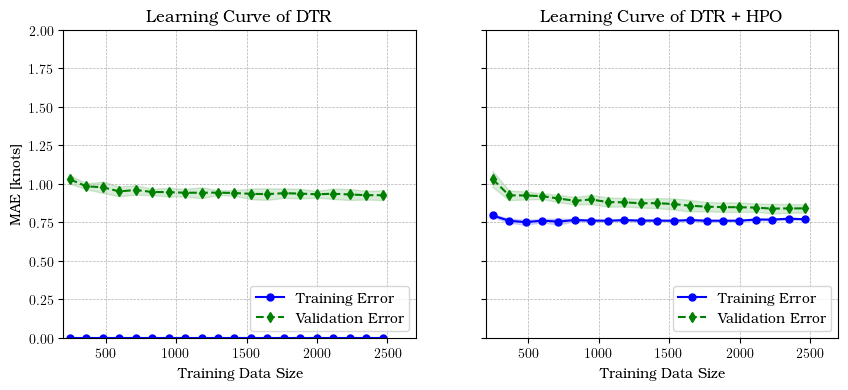

In [76]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotrmse(model_dtr,x_train,y_train,'DTR')
plt.sca(axes[1])
learn_plotrmse(model_dtr_hpov,x_train,y_train,'DTR + HPO')
plt.ylabel("")
plt.show()

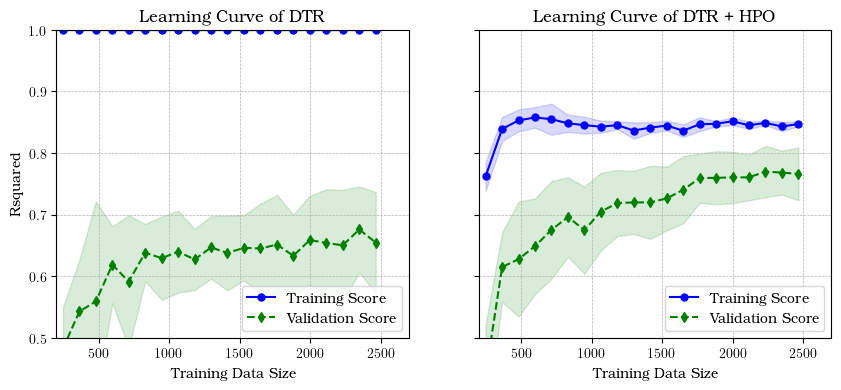

In [77]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotr2(model_dtr,x_train,y_train,'DTR')
plt.sca(axes[1])
learn_plotr2(model_dtr_hpov,x_train,y_train,'DTR + HPO')
plt.ylabel("")
plt.show()

Learning Curve RFR

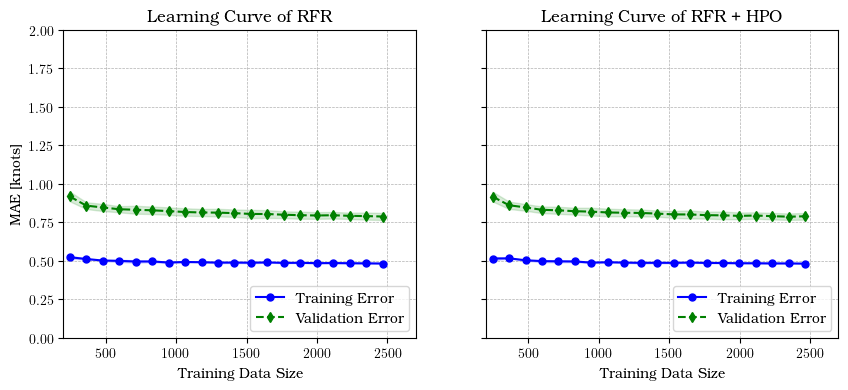

In [78]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotrmse(model_rfr_ftr,x_train,y_train,'RFR')
plt.sca(axes[1])
learn_plotrmse(model_rfr_ftr_hpov,x_train,y_train,'RFR + HPO')
plt.ylabel("")
plt.show()

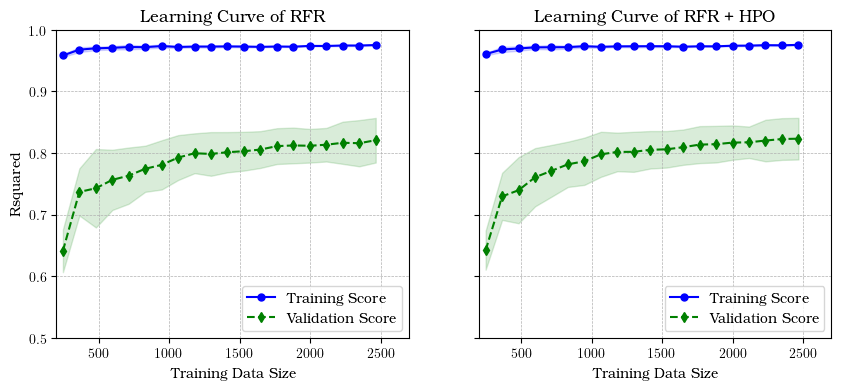

In [79]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotr2(model_rfr_ftr,x_train,y_train,'RFR')
plt.sca(axes[1])
learn_plotr2(model_rfr_ftr_hpov,x_train,y_train,'RFR + HPO')
plt.ylabel("")
plt.show()

Learning Curve ETR

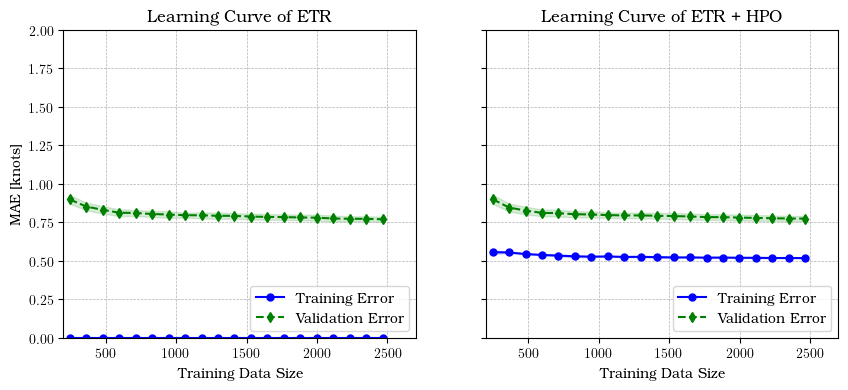

In [80]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotrmse(model_etr,x_train,y_train,'ETR')
plt.sca(axes[1])
learn_plotrmse(model_etr_hpov,x_train,y_train,'ETR + HPO')
plt.ylabel("")
plt.show()

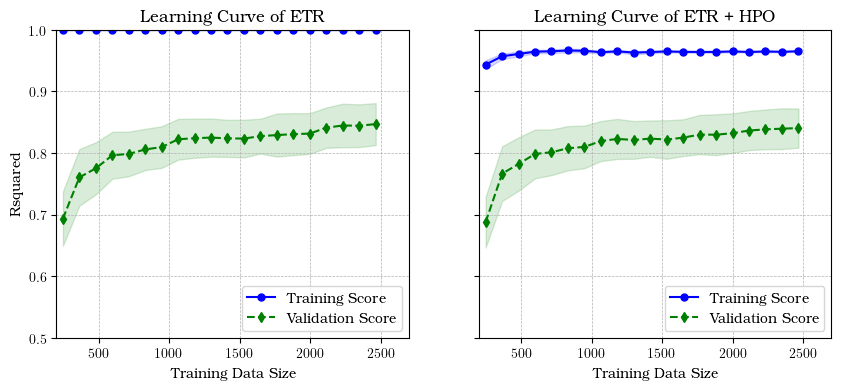

In [81]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotr2(model_etr,x_train,y_train,'ETR')
plt.sca(axes[1])
learn_plotr2(model_etr_hpov,x_train,y_train,'ETR + HPO')
plt.ylabel("")
plt.show()

Box plot for evaluations

<Figure size 500x300 with 0 Axes>

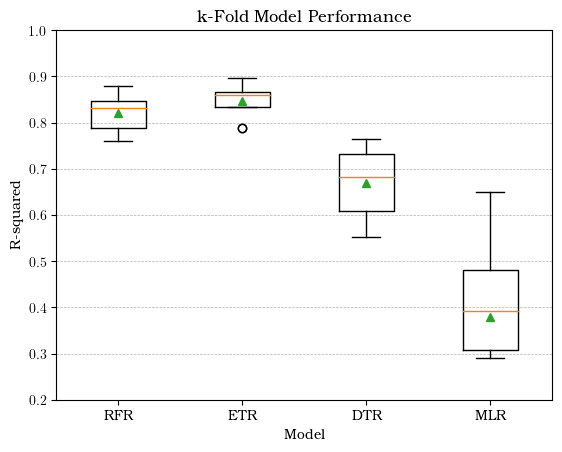

In [82]:
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [r2_rf,r2_et,r2_dt,r2_mlr]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("k-Fold Model Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0.2,1.0)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR', 'MLR'])
plt.show()

<Figure size 500x300 with 0 Axes>

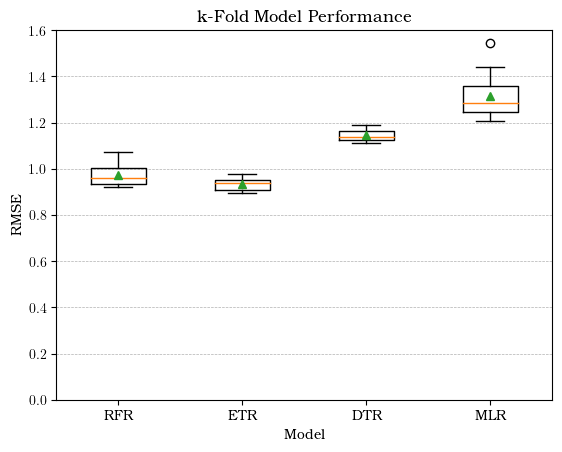

In [83]:
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores_rmse = [np.abs(RMSE_rf),np.abs(RMSE_et),np.abs(RMSE_dt),np.abs(RMSE_mlr)]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("k-Fold Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.ylim(0,1.6)
plt.yscale('linear')
ax.boxplot(scores_rmse,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR', 'MLR'])
plt.show()

Comparison for optimised model

In [84]:
def r2_plot_opt(r2_mod1,r2_mod1opt,r2_mod2,r2_mod2opt,r2_mod3,r2_mod3opt):
    scores_opt = [r2_mod1,r2_mod1opt,r2_mod2,r2_mod2opt,r2_mod3,r2_mod3opt]
    # fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("k-Fold Model Performance")
    plt.ylabel("R-squared")
    plt.xlabel("Model")
    plt.ylim(0.2,1.0)
    plt.yscale('linear')
    ax.boxplot(scores_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                        r'ETR', r'$ETR_{opt}$',
                        r'DTR',r'$DTR_{opt}$'])

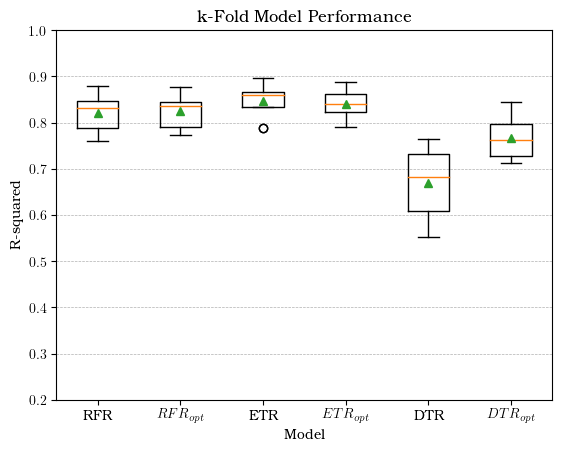

In [85]:
r2_plot_opt(r2_rf,r2_rfo,r2_et,r2_eto,r2_dt,r2_dto)
plt.show()

In [86]:
def rmse_plot_opt(rmse_mod1,rmse_mod1opt,rmse_mod2,rmse_mod2opt,rmse_mod3,rmse_mod3opt):
    rmse_opt = [rmse_mod1,rmse_mod1opt,rmse_mod2,rmse_mod2opt,rmse_mod3,rmse_mod3opt]
    # fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("k-Fold Model Performance")
    plt.ylabel("RMSE [knots]")
    plt.xlabel("Model")
    plt.yscale('linear')
    plt.ylim(0,1.4)
    ax.boxplot(rmse_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                        r'ETR', r'$ETR_{opt}$',
                        r'DTR',r'$DTR_{opt}$'])

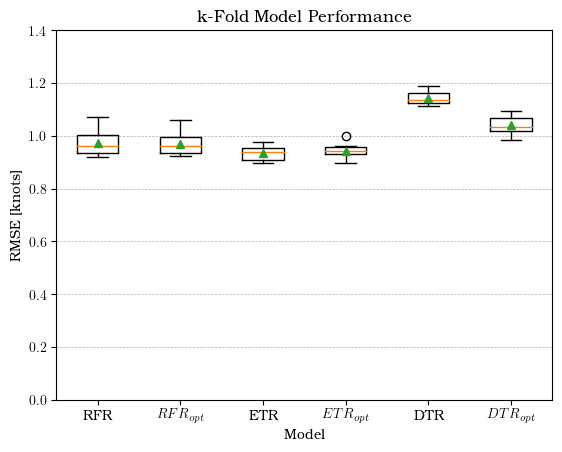

In [87]:
rmse_plot_opt(RMSE_rf,RMSE_rfo,RMSE_et,RMSE_eto,RMSE_dt,RMSE_dto)
plt.show()


In [88]:
def mae_plot_opt(mae_mod1,mae_mod1opt,mae_mod2,mae_mod2opt,mae_mod3,mae_mod3opt):
    mae_opt = [mae_mod1,mae_mod1opt,mae_mod2,mae_mod2opt,mae_mod3,mae_mod3opt]
    fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("k-Fold Model Performance")
    plt.ylabel("MAE [knots]")
    plt.xlabel("Model")
    plt.yscale('linear')
    plt.ylim(0,1.4)
    ax.boxplot(mae_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                        r'ETR', r'$ETR_{opt}$',
                        r'DTR',r'$DTR_{opt}$'])

<Figure size 500x300 with 0 Axes>

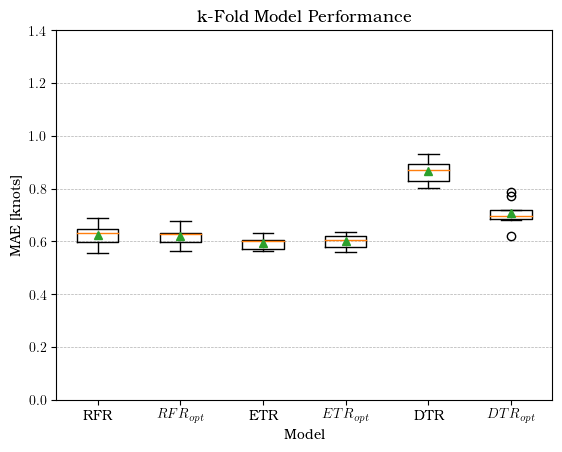

In [89]:
mae_plot_opt(-MAE_rf,-MAE_rfo,-MAE_et,-MAE_eto,-MAE_dt,-MAE_dto)
plt.show()

In [90]:
def mad_plot_opt(mad_mod1,mad_mod1opt,mad_mod2,mad_mod2opt,mad_mod3,mad_mod3opt):
    mad_opt = [mad_mod1,mad_mod1opt,mad_mod2,mad_mod2opt,mad_mod3,mad_mod3opt]
    fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("k-Fold Model Performance")
    plt.ylabel("MAD [knots]")
    plt.xlabel("Model")
    plt.yscale('linear')
    plt.ylim(0,1.4)
    ax.boxplot(mad_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                        r'ETR', r'$ETR_{opt}$',
                        r'DTR',r'$DTR_{opt}$'])

<Figure size 500x300 with 0 Axes>

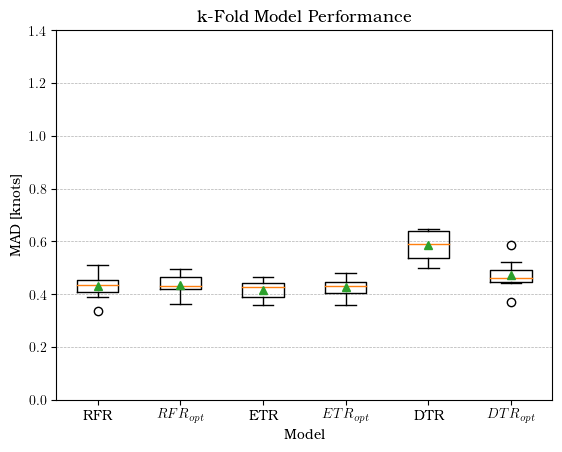

In [91]:
mad_plot_opt(-MAD_rf,-MAD_rfo,-MAD_et,-MAD_eto,-MAD_dt,-MAD_dto)
plt.show()